# Convolutional Neural Network

### Importing the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import numpy as np

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

os.environ["TF_DETERMINISTIC_OPS"] = "1"
tf.config.experimental.enable_op_determinism()

In [2]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

x_train_flat = x_train.reshape((x_train.shape[0], -1))

df_train = pd.DataFrame(x_train_flat)

df_train['label'] = y_train

print(df_train.shape)
df_train.head()

label_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

df_train['class_name'] = df_train['label'].map(lambda x: label_map[int(x)])
df_train.head()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
(50000, 3073)


,0,1,2,3,4,5,6,7,8,9,...,3064,3065,3066,3067,3068,3069,3070,3071,label,class_name
0,59.0,62.0,63.0,43.0,46.0,45.0,50.0,48.0,43.0,68.0,...,184.0,140.0,151.0,118.0,84.0,123.0,92.0,72.0,6,frog
1,154.0,177.0,187.0,126.0,137.0,136.0,105.0,104.0,95.0,102.0,...,133.0,139.0,143.0,134.0,142.0,143.0,133.0,144.0,9,truck
2,255.0,255.0,255.0,253.0,253.0,253.0,253.0,253.0,253.0,253.0,...,85.0,83.0,79.0,85.0,83.0,80.0,86.0,84.0,9,truck
3,28.0,25.0,10.0,37.0,34.0,19.0,38.0,35.0,20.0,42.0,...,47.0,28.0,63.0,56.0,37.0,72.0,65.0,46.0,4,deer
4,170.0,180.0,198.0,168.0,178.0,196.0,177.0,185.0,203.0,183.0,...,79.0,82.0,71.0,75.0,78.0,73.0,77.0,80.0,1,automobile


## Data Preprocessing

In [3]:
df_test = pd.DataFrame(x_test.reshape((x_test.shape[0], -1)))
df_test['label'] = y_test
df_test['class_name'] = df_test['label'].map(lambda x: label_map[int(x)])
print(df_test.shape)
df_test.head()

(10000, 3074)


,0,1,2,3,4,5,6,7,8,9,...,3064,3065,3066,3067,3068,3069,3070,3071,label,class_name
0,158.0,112.0,49.0,159.0,111.0,47.0,165.0,116.0,51.0,166.0,...,77.0,124.0,34.0,84.0,129.0,21.0,67.0,110.0,3,cat
1,235.0,235.0,235.0,231.0,231.0,231.0,232.0,232.0,232.0,232.0,...,183.0,178.0,180.0,195.0,191.0,186.0,200.0,199.0,8,ship
2,158.0,190.0,222.0,158.0,187.0,218.0,139.0,166.0,194.0,132.0,...,6.0,8.0,4.0,5.0,3.0,7.0,8.0,7.0,8,ship
3,155.0,156.0,149.0,167.0,176.0,187.0,176.0,179.0,193.0,190.0,...,63.0,50.0,64.0,65.0,52.0,73.0,68.0,50.0,0,airplane
4,65.0,68.0,50.0,70.0,81.0,64.0,48.0,64.0,46.0,30.0,...,179.0,136.0,154.0,185.0,146.0,128.0,156.0,117.0,6,frog


In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

y = df_train['label'].values

sss = StratifiedShuffleSplit(n_splits=1, test_size=10000, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(y)), y))

df_train_new = df_train.iloc[train_idx].reset_index(drop=True)
df_val = df_train.iloc[val_idx].reset_index(drop=True)

print("Training set:", df_train_new.shape)
print("Validation set:", df_val.shape)

Training set: (40000, 3074)
Validation set: (10000, 3074)


### Preprocessing the Training set

In [5]:
def cutout(image, mask_size=8):
    image = image.copy()
    h, w = image.shape[0], image.shape[1]
    y = np.random.randint(h)
    x = np.random.randint(w)
    y1 = np.clip(y - mask_size // 2, 0, h)
    y2 = np.clip(y + mask_size // 2, 0, h)
    x1 = np.clip(x - mask_size // 2, 0, w)
    x2 = np.clip(x + mask_size // 2, 0, w)
    image[y1:y2, x1:x2, :] = 0
    return image

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   channel_shift_range=0.1,
                                   brightness_range=[0.9,1.1],
                                   fill_mode='reflect',
                                   horizontal_flip = True,
                                   preprocessing_function=cutout)
training_set = train_datagen.flow(x=df_train_new.drop(['label', 'class_name'], axis=1).values.reshape(-1, 32, 32, 3),
                                  y=tf.keras.utils.to_categorical(df_train_new['label'].values, num_classes=10),
                                  batch_size = 32)

### Preprocessing the Test set

In [7]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_set = val_datagen.flow(x=df_val.drop(['label', 'class_name'], axis=1).values.reshape(-1, 32, 32, 3),
                                       y=tf.keras.utils.to_categorical(df_val['label'].values, num_classes=10),
                                       batch_size=32,
                                       seed=42)

In [8]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow(x=x_test,
                                 y=tf.keras.utils.to_categorical(y_test, num_classes=10),
                                 batch_size=32,
                                 shuffle=False)

## Building the CNN

# First Convolution Layer

In [9]:
cnn = tf.keras.models.Sequential([
    tf.keras.Input(shape=(32, 32, 3))
])

In [10]:
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3, activation='relu', padding='same'))
cnn.add(tf.keras.layers.BatchNormalization())

### Pooling & Dropout

In [11]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Second Convolutional Layer

In [12]:
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu',padding='same'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Third Convolution Layer


In [13]:
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu',padding='same'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Fourth Convolution Layer

In [14]:
cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Fifth Convolution Layer

In [15]:
cnn.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='same'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Flattening

In [16]:
cnn.add(tf.keras.layers.GlobalAveragePooling2D())

# Full Connection

In [17]:
cnn.add(tf.keras.layers.Dense(units=512, activation='relu'))

# Output Layer

In [18]:
cnn.add(tf.keras.layers.Dense(units=10, activation='softmax'))

## Training the CNN

### Compiling the CNN

In [19]:
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Training the CNN on the Training set and evaluating it on the Test set

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
history = cnn.fit(
    x=training_set,
    validation_data=val_set,
    epochs=50,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 53ms/step - accuracy: 0.3792 - loss: 1.7676 - val_accuracy: 0.4228 - val_loss: 1.8333 - learning_rate: 0.0010
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 74s 50ms/step - accuracy: 0.5593 - loss: 1.2372 - val_accuracy: 0.6108 - val_loss: 1.0927 - learning_rate: 0.0010
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 63s 50ms/step - accuracy: 0.6184 - loss: 1.0792 - val_accuracy: 0.6818 - val_loss: 0.9053 - learning_rate: 0.0010
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 51ms/step - accuracy: 0.6508 - loss: 0.9950 - val_accuracy: 0.6723 - val_loss: 0.9647 - learning_rate: 0.0010
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - accuracy: 0.6774 - loss: 0.9226 - val_accuracy: 0.7197 - val_loss: 0.7944 - learning_rate: 0.0010
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 50ms/step - accuracy: 0.6966 - loss: 0.8617 - val_accuracy: 0.7310 - val_loss: 0.8059 - learning_rate: 0.0010
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7155 -

In [21]:
loss_train, accuracy_train = cnn.evaluate(training_set)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy_train, loss_train))
loss_test, accuracy_test = cnn.evaluate(test_set)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy_test, loss_test))
loss_val, accuracy_val = cnn.evaluate(val_set)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy_val, loss_val))
cnn.save("classification-model.keras")

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.8773 - loss: 0.3363
Train: accuracy = 0.880450  ;  loss = 0.332788
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8427 - loss: 0.4726
Test: accuracy = 0.844500  ;  loss = 0.468574
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8602 - loss: 0.4329
Validation: accuracy = 0.848300  ;  loss = 0.453621


# History Plot

In [22]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    #plot for model accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1))
    axs[0].legend(['train', 'val'], loc='best')
    #Plot for model loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

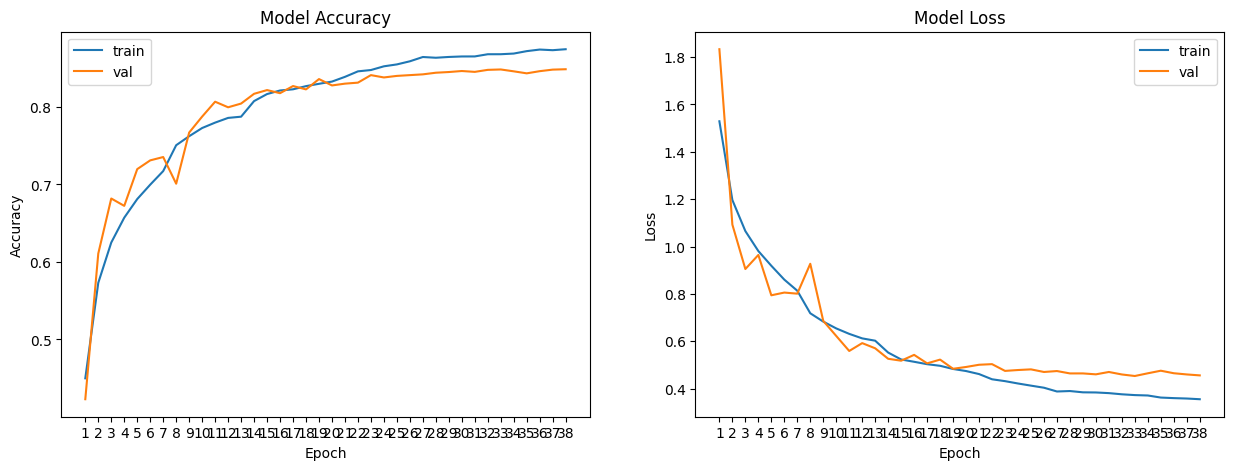

In [23]:
plot_model_history(history)

## Performance Evaluation Report

In [24]:
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model = keras.models.load_model("classification-model.keras")

y_true = y_test.flatten().astype(int)

y_pred_prob = model.predict(test_set, verbose=0)

print(f"Prediction shape: {y_pred_prob.shape}")

y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_true, y_pred)

precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nDetailed Report:")
print(classification_report(y_true, y_pred, target_names=label_map.values()))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Prediction shape: (10000, 10)
Accuracy: 0.8445
Precision: 0.8433
Recall: 0.8445

Detailed Report:
              precision    recall  f1-score   support

    airplane       0.85      0.90      0.87      1000
  automobile       0.87      0.95      0.91      1000
        bird       0.82      0.79      0.81      1000
         cat       0.77      0.64      0.70      1000
        deer       0.86      0.78      0.82      1000
         dog       0.78      0.74      0.76      1000
        frog       0.81      0.93      0.87      1000
       horse       0.87      0.91      0.89      1000
        ship       0.93      0.89      0.91      1000
       truck       0.88      0.91      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000


Confusion Matrix:
[[900  20  12   6   8   2   1   6  18  27]
 [  3 950   1   3   0   0   5   0   8  30]
 [ 45   5 790  22  31  34  44  19   6 

# Sample predictions on test images

In [25]:
sample_set = test_set
pred_probs = model.predict(sample_set)
pred_classes = np.argmax(pred_probs, axis=1)

true_classes = y_test.flatten().astype(int)
class_labels = list(label_map.values())

loss_sample, accuracy_sample = model.evaluate(sample_set)
print("Sample: accuracy = %f  ;  loss = %f" % (accuracy_sample, loss_sample))

pred_labels = [class_labels[p] for p in pred_classes]
true_labels = [class_labels[t] for t in true_classes]
print("Sample Set: ")
for i in range(len(pred_labels)):
    print(f"Predicted: {pred_labels[i]}  |  Actual: {true_labels[i]}")

Streaming output truncated to the last 5000 lines.
Predicted: horse  |  Actual: horse
Predicted: frog  |  Actual: frog
Predicted: ship  |  Actual: ship
Predicted: deer  |  Actual: deer
Predicted: deer  |  Actual: deer
Predicted: dog  |  Actual: dog
Predicted: horse  |  Actual: horse
Predicted: cat  |  Actual: cat
Predicted: deer  |  Actual: deer
Predicted: bird  |  Actual: horse
Predicted: horse  |  Actual: horse
Predicted: frog  |  Actual: cat
Predicted: frog  |  Actual: frog
Predicted: airplane  |  Actual: airplane
Predicted: horse  |  Actual: horse
Predicted: bird  |  Actual: bird
Predicted: frog  |  Actual: frog
Predicted: horse  |  Actual: horse
Predicted: deer  |  Actual: deer
Predicted: automobile  |  Actual: automobile
Predicted: ship  |  Actual: ship
Predicted: airplane  |  Actual: airplane
Predicted: bird  |  Actual: bird
Predicted: bird  |  Actual: bird
Predicted: automobile  |  Actual: automobile
Predicted: dog  |  Actual: dog
Predicted: deer  |  Actual: deer
Predicted: air

# Model Architecture Diagram

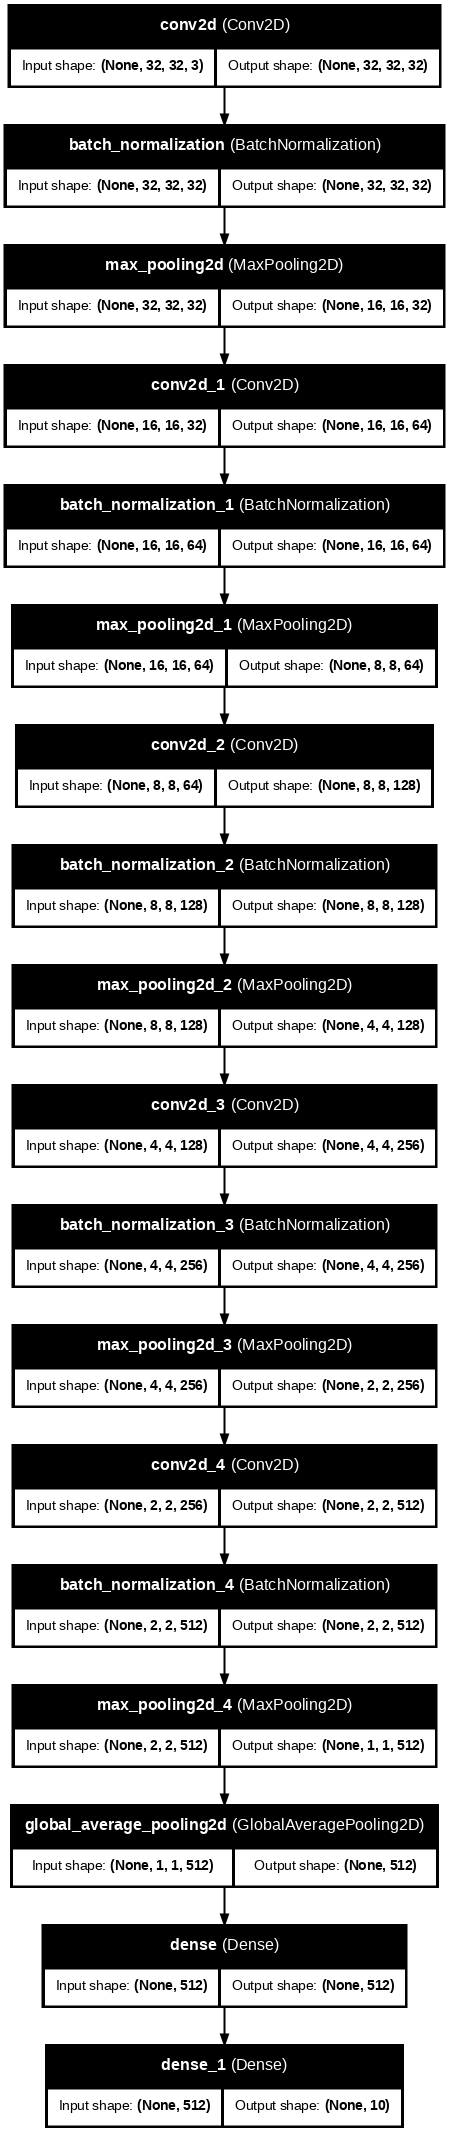

In [26]:
from tensorflow.keras.utils import plot_model
model = tf.keras.models.load_model("classification-model.keras")
plot_model(model, to_file="model_architecture.png",
           show_shapes=True,
           show_layer_names=True,
           dpi=72)
